In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Random crop and resize to 224x224
        transforms.RandomRotation(30),      # Randomly rotate by up to 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

dataset_classify = datasets.ImageFolder('data/borderline_negative/')

train_size = int(0.8 * len(dataset_classify))
test_size = len(dataset_classify) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset_classify, [train_size, test_size])

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
train_dataset = CustomDataset(train_dataset, transform=data_transforms['train'])
test_dataset = CustomDataset(test_dataset, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# classes in train_loader:
for x, y in train_loader:
    print(y)
    break

tensor([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1])


In [4]:
# Load pretrained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, len(dataset_classify.classes))

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [6]:
# use gpu if available
device = torch.device("cuda:0") # change to CPU if no CUDA
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [7]:
from tqdm import tqdm
num_epochs = 10 # Number of epochs

for epoch in range(num_epochs):
    # Training loop
    model.train()

    running_loss = 0.0
    num_batches = 0
    train_correct = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        running_loss, num_batches = running_loss + loss.item(), num_batches + 1
        # Backward and optimize
        loss.backward()
        optimizer.step()
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/num_batches:.4f}, correct during training: {train_correct}')

    model.eval()
    # Validation loop
    with torch.no_grad():
        running_accuracy = 0.0
        total_correct = 0 
        num_batches = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            num_batches += 1
            total_correct += (outputs.argmax(dim=1) == labels).type(torch.float).sum().item()
        running_accuracy = total_correct / len(test_loader.dataset) * 100
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {running_accuracy}%')


100%|██████████| 19/19 [02:41<00:00,  8.52s/it]


Epoch [1/10], Loss: 0.6855, correct during training: 1294
Epoch [1/10], Test Accuracy: 59.86733001658375%


 37%|███▋      | 7/19 [01:02<01:47,  8.97s/it]

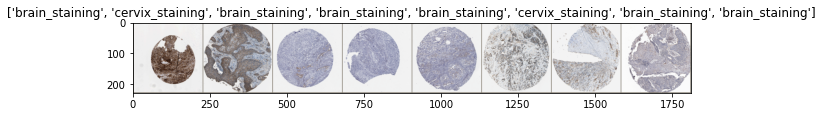

In [ ]:
# visualize the test set
import torchvision
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
with torch.no_grad():
    inputs, classes = next(iter(test_loader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[dataset_classify.classes[x] for x in classes])
